<a href="https://colab.research.google.com/github/coderacheal/Its-Sunday/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
%pip install transformers

Looking in indexes: https://download.pytorch.org/whl/cu117, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.6 MB/s eta 0:00:00


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

df =  pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset.csv')
df

,Text,Language,Label
0,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...,en,litigious
1,#BadBunny: Como dos gotas de agua: Joven se di...,es,negative
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,en,litigious
3,Rwanda is set to host the headquarters of Unit...,en,positive
4,OOPS. I typed her name incorrectly (today’s br...,en,litigious
...,...,...,...
937849,@Juice_Lemons in the dark. it’s so good,en,positive
937850,8.SSR &amp; Disha Salian case should be solved...,en,negative
937851,*ACCIDENT: Damage Only* - Raleigh Fire Depart...,en,negative
937852,@reblavoie So happy for her! She’s been incred...,en,positive


In [5]:
df.shape

(937854, 3)

In [6]:
df['Language'].unique()

array(['en', 'es', 'ca', 'fr', 'pt', 'ja', 'hi', 'ar', 'ko', 'nl', 'et',
       'in', 'und', 'tl', 'zh', 'de', 'cs', 'ru', 'qme', 'it', 'el', 'ro',
       'no', 'tr', 'sv', 'ta', 'fa', 'ht', 'pl', 'da', 'th', 'hu', 'lv',
       'uk', 'qht', 'eu', 'qam', 'si', 'cy', 'zxx', 'ml', 'ne', 'mr',
       'qst', 'vi', 'bn', 'gu', 'is', 'fi', 'ckb', nan, 'te', 'art', 'bg',
       'ur', 'sl', 'lt', 'pa', 'iw', 'kn', 'sr',
       "[Photo(previewUrl='https://pbs.twimg.com/media/FWV94O7UEAAjMOi?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/FWV94O7UEAAjMOi?format=jpg&name=large')]",
       "[Photo(previewUrl='https://pbs.twimg.com/media/FWWBzWTXkAAyZqm?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/FWWBzWTXkAAyZqm?format=jpg&name=large')]",
       'am', 'or',
       "[Photo(previewUrl='https://pbs.twimg.com/media/EPYG2rKVAAA1e_O?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/EPYG2rKVAAA1e_O?format=jpg&name=large')]",
       'sd',
       "[Photo(previewUrl='h

In [7]:
english_df = df[df['Language'] =='en']

#let's drop the language column
english_df.drop(columns='Language', inplace=True)


In [8]:

uncertainty_df = english_df[df['Label'] =='uncertainty'][:30000]
positive_df = english_df[df['Label'] =='positive'][:30000]
negative_df = english_df[df['Label'] =='negative'][:30000]
litigious_df = english_df[df['Label'] =='litigious'][:1200]

In [9]:
uncertainty_df

,Text,Label
7,@ShawnTarloff @itsmieu you can also relate thi...,uncertainty
22,ew its almost valentine’s day https://t.co/FA5...,uncertainty
25,@BlackMercury3 I’m thinking that maybe Ironwoo...,uncertainty
29,@zoidberg95 Infinite Diversity in Infinite Com...,uncertainty
33,Sad thing is.. he's causing more damage than T...,uncertainty
...,...,...
142795,@Sidelinecreepin i’m the opposite. i root for ...,uncertainty
142811,@donwinslow @PressSec Maybe she could a press ...,uncertainty
142814,Can't believe it's been almost 10 years since ...,uncertainty
142830,@Kat_Ozburn Public school can be great. Of cou...,uncertainty


In [10]:
uncertainty_df['Text'][7]

'@ShawnTarloff @itsmieu you can also relate this to art too!!! a lot of people are dismayed in starting art because of this kind of thing and i always try to tell them that everyone starts somewhere and those who are "good" by certain ages just trained enough to get there, like with anything you learn'

## Feature Engineering

 - Engineer the litigious label to make it more extensive

In [11]:
import pandas as pd

new_records = []

litigious_sentences = [
    'The plaintiff alleges that the defendant committed defamation by spreading false and damaging statements about their character.',
    'The company is facing a lawsuit for patent infringement due to their unauthorized use of a patented technology.',
    'The accused party is being sued for breach of contract, as they failed to fulfill their obligations as outlined in the signed agreement.',
    'I will bury this place in so much law suit that your grand children are going to need lawyers',
    'The plaintiff claims substantial damages resulting from the defendant\'s fraudulent activities, including misrepresentation of financial information.',
    'The employer is facing a legal battle over allegations of wrongful termination and violation of labor laws, as the employee argues they were fired without just cause.',
    'The plaintiff seeks compensation for the alleged negligence of the defendant, which resulted in personal injury and financial loss.',
    'The company filed a lawsuit against its former employee for alleged misappropriation of trade secrets, claiming significant damages.',
    'The court issued an injunction to prevent the defendant from further trademark violation and ordered them to cease all unauthorized use of the protected mark.',
    'The plaintiff accuses the defendant of libel and slander, claiming that the false statements made by the defendant harmed their personal and professional reputation.',
    'The dispute between the two parties arose from an alleged breach of fiduciary duty, with the plaintiff asserting that the defendant prioritized personal gain over their legal obligations.',
    'The neighbors filed a complaint against each other for alleged trespassing, seeking a restraining order to prevent further disputes.',
    'The landlord is facing a lawsuit from the tenant, claiming breach of contract due to the landlord\'s failure to address necessary repairs in a timely manner.',
    'A legal battle between former spouses ensued over child custody, with both parties accusing each other of parental alienation and seeking sole custody rights.',
    'The homeowners\' association sent a cease and desist letter to a resident for violating community guidelines by conducting business activities from their home.',
    'Siblings engaged in a dispute over their late parent\'s estate, resulting in a contentious probate case with allegations of undue influence and mismanagement of assets.'
]

for i in range(1800):
  for sentence in litigious_sentences:
    text = sentence
    label = 'litigious'
    record = {'Text': text, 'Label': label}
    new_records.append(record)


engineered_litigious_df = pd.DataFrame(new_records)

engineered_litigious_df.head()

,Text,Label
0,The plaintiff alleges that the defendant commi...,litigious
1,The company is facing a lawsuit for patent inf...,litigious
2,The accused party is being sued for breach of ...,litigious
3,I will bury this place in so much law suit tha...,litigious
4,The plaintiff claims substantial damages resul...,litigious


In [12]:
engineered_litigious_df.shape

(28800, 2)

In [13]:
data = pd.concat([litigious_df, uncertainty_df, positive_df, negative_df, engineered_litigious_df], axis=0, ignore_index=True)
data

,Text,Label
0,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...,litigious
1,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,litigious
2,OOPS. I typed her name incorrectly (today’s br...,litigious
3,@SaltBurned [When the first sign of surrender ...,litigious
4,"""It's Your fight to save the UK from the liars...",litigious
...,...,...
119995,The neighbors filed a complaint against each o...,litigious
119996,The landlord is facing a lawsuit from the tena...,litigious
119997,A legal battle between former spouses ensued o...,litigious
119998,The homeowners' association sent a cease and d...,litigious


## EDA

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    120000 non-null  object
 1   Label   120000 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


In [15]:
sentiments = data['Label'].value_counts().sort_values(ascending=False)
sentiments

litigious      30000
uncertainty    30000
positive       30000
negative       30000
Name: Label, dtype: int64

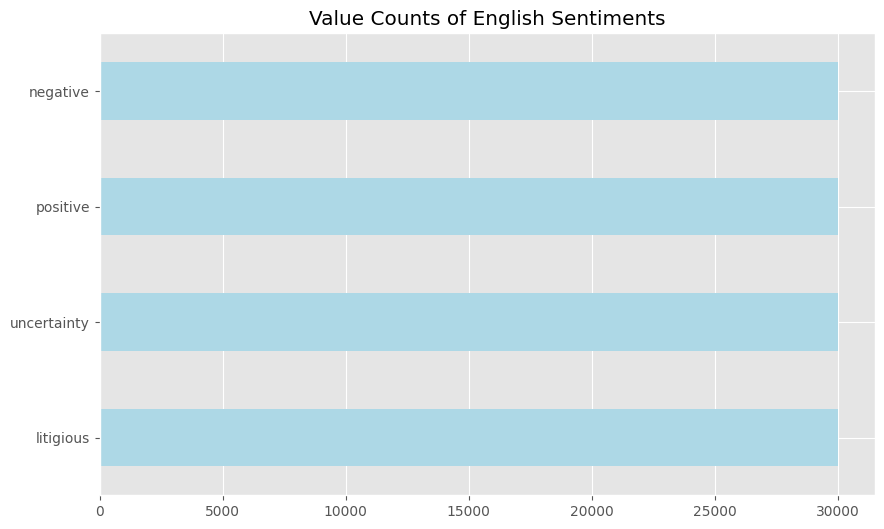

In [16]:
sentiments.plot(kind='barh', color='lightblue', figsize=(10,6))
plt.title('Value Counts of English Sentiments')
plt.show()

### Data Cleaning

1. Remove usernames from tweets
2. Remove hashtags from tweets
3. Remove things like http links and \n form tweet

##### Let's start with usernames

- We need to remove the usernames that follow the @ symbol. The symbol will be removed as well
- Write a function using the re module

In [17]:
# before
data['Text'][0]

'@Charlie_Corley @Kristine1G @amyklobuchar @StyleWriterNYC testimony is NOT evidence in a court of law, state or federal. Must stand up to cross examination'

In [18]:
def remove_usernames(text):
    pattern = r'@\w+\s?'
    result = re.sub(pattern, '', text)
    return result


data['Text'] = data['Text'].apply(remove_usernames)
data

,Text,Label
0,"testimony is NOT evidence in a court of law, s...",litigious
1,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,litigious
2,OOPS. I typed her name incorrectly (today’s br...,litigious
3,"[When the first sign of surrender comes, Micha...",litigious
4,"""It's Your fight to save the UK from the liars...",litigious
...,...,...
119995,The neighbors filed a complaint against each o...,litigious
119996,The landlord is facing a lawsuit from the tena...,litigious
119997,A legal battle between former spouses ensued o...,litigious
119998,The homeowners' association sent a cease and d...,litigious


In [19]:
# after
data['Text'][0]

'testimony is NOT evidence in a court of law, state or federal. Must stand up to cross examination'

In [20]:
# corresponding label
data['Label'][0]

'litigious'

##### Next, hashtags

- We need to remove the hashtags that follow the @ symbol.
- Write a function using the re module

In [21]:
# before
data['Text'][100000]

'The plaintiff alleges that the defendant committed defamation by spreading false and damaging statements about their character.'

In [22]:
data['Label'][100000]

'litigious'

In [23]:
def remove_hastags(text):
    pattern = r'#\w+\s?'
    result = re.sub(pattern, '', text)
    return result


data['Text'] = data['Text'].apply(remove_hastags)
data

,Text,Label
0,"testimony is NOT evidence in a court of law, s...",litigious
1,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,litigious
2,OOPS. I typed her name incorrectly (today’s br...,litigious
3,"[When the first sign of surrender comes, Micha...",litigious
4,"""It's Your fight to save the UK from the liars...",litigious
...,...,...
119995,The neighbors filed a complaint against each o...,litigious
119996,The landlord is facing a lawsuit from the tena...,litigious
119997,A legal battle between former spouses ensued o...,litigious
119998,The homeowners' association sent a cease and d...,litigious


#### Next, hashtags

- We need to remove the hashtags that follow the @ symbol.
- Write a function using the re module

In [24]:
#after there are not more hashtags
data['Text'][3]

'[When the first sign of surrender comes, Michael’s smile splits his face like a sharp knife through flesh. It would chill Dean to his very core if he were to witness this ice cold existence and its nature, and the Archangel would have an enjoyable time »'

##### Next, http links

- We need to remove all http links.
- Write a function using the re module

In [25]:
#before
data['Text'][3]

'[When the first sign of surrender comes, Michael’s smile splits his face like a sharp knife through flesh. It would chill Dean to his very core if he were to witness this ice cold existence and its nature, and the Archangel would have an enjoyable time »'

In [26]:
def remove_urls(string):
    pattern = r'https?://\S+'
    result = re.sub(pattern, '', string)
    return result

data['Text'] = data['Text'].apply(remove_urls)

In [27]:
#after
data['Text'][203]

'a family issue put her in witness protection as a child.'


##### Remove special characters

- We need to remove * and newline characters (\n).
- Write a function using the re module

In [28]:
#before
data['Text'].unique()

array(['testimony is NOT evidence in a court of law, state or federal. Must stand up to cross examination',
       ' Flagstar Bank discloses a data breach that impacted 1.5\nMillion individuals ',
       'OOPS. I typed her name incorrectly (today’s brave witness) . 6. 7. (probaby) . Don’t forget requesting a . ',
       ...,
       'A legal battle between former spouses ensued over child custody, with both parties accusing each other of parental alienation and seeking sole custody rights.',
       "The homeowners' association sent a cease and desist letter to a resident for violating community guidelines by conducting business activities from their home.",
       "Siblings engaged in a dispute over their late parent's estate, resulting in a contentious probate case with allegations of undue influence and mismanagement of assets."],
      dtype=object)

In [29]:
def remove_special_chars(text):
    pattern = r'[*\n]'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

data['Text'] = data['Text'].apply(remove_special_chars)
data.head()

,Text,Label
0,"testimony is NOT evidence in a court of law, s...",litigious
1,Flagstar Bank discloses a data breach that im...,litigious
2,OOPS. I typed her name incorrectly (today’s br...,litigious
3,"[When the first sign of surrender comes, Micha...",litigious
4,"""It's Your fight to save the UK from the liars...",litigious


### Let's shuffle the dataset because of the engineering we did

In [30]:
data = data.sample(frac=1, random_state=42)  # Frac=1 ensures all rows are included, random_state for reproducibility

data.head()


,Text,Label
71787,"I wish i had a ps5, still on the ps4 and can’t...",negative
67218,Our air conditioner at my job is broken again 😭,negative
54066,Wait you don't think a true Trumper is easier ...,positive
7168,‘Too much risk’: why Erasmus students are shun...,uncertainty
29618,Maybe they should try eating Lean Kwehsine.,uncertainty


# Let's Train a Bert Model with a quarter million Tweets

#### Creating Tokenizer and Model

Let's convert our text and label column into list for easy splitting



In [31]:
X = data['Text'].to_list()
y = data['Label'].to_list()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(y_train)

In [32]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode the training texts
train_encodings = tokenizer(X_train, truncation=True, padding=True)
train_labels = torch.tensor(train_labels)

In [33]:
# Tokenize and encode the test texts
test_encodings = tokenizer(X_test, truncation=True, padding=True)
test_labels = torch.tensor(label_encoder.transform(y_test))

In [34]:
# Create train and test datasets
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [35]:

train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

In [36]:
#Create train and test dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [37]:
# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [38]:
# Set device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [39]:
# Set training parameters
num_epochs = 1
optimizer = AdamW(model.parameters(), lr=1e-5)

In [40]:
#Training loop
for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

In [41]:
# Evaluation loop
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(logits.argmax(dim=1).cpu().numpy().tolist())


In [47]:
# evaluate perfomance of model
model.eval()

# Initialize lists for storing true labels and predicted labels
true_labels = []
predicted_labels = []

# Initialize list for storing predicted probabilities
predicted_probs = []

# Iterate over the test dataset
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_classes = logits.argmax(dim=1)
        probabilities = torch.softmax(logits, dim=1)

        # Store true labels and predicted labels
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted_classes.tolist())
        
        # Store predicted probabilities
        predicted_probs.extend(probabilities.tolist())

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.9745
Precision: 0.9745919056082964
Recall: 0.9745
F1 Score: 0.974485189992306


In [45]:
# Input text for prediction
input_text = "hoho ho and a bottle of ram"

# Tokenize and encode the input text
input_encoding = tokenizer(input_text, truncation=True, padding=True, return_tensors='pt')

# Make predictions
model.eval()
with torch.no_grad():
    input_ids = input_encoding['input_ids'].to(device)
    attention_mask = input_encoding['attention_mask'].to(device)

    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predicted_labels = logits.argmax(dim=1)

# Convert predicted labels back to original classes using label_encoder
predicted_classes = label_encoder.inverse_transform(predicted_labels.cpu().numpy())

# Print the predicted class
print("Predicted class:", predicted_classes[0])


Predicted class: positive


### Persist Model

In [49]:
# Save the model
model.save_pretrained('my_retrained_bert_model')
